1. Import Libraries and Load Dataset via KaggleHub



In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

import kagglehub

# Download dataset using kagglehub
path = kagglehub.dataset_download("aslanahmedov/walmart-sales-forecast")
print("Path to dataset files:", path)


Path to dataset files: /kaggle/input/walmart-sales-forecast


2. Load and Explore the Dataset

In [5]:
# The actual file is inside the downloaded path
csv_path = path + "/train.csv"

# Load data
df = pd.read_csv(csv_path)

# Preview
print("Shape of dataset:", df.shape)
df.head()


Shape of dataset: (421570, 5)


,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


3. Basic Exploration

In [6]:
print("Columns:", df.columns.tolist())
print("Missing values:\n", df.isnull().sum())

# Check datatypes
df.dtypes


Columns: ['Store', 'Dept', 'Date', 'Weekly_Sales', 'IsHoliday']
Missing values:
 Store           0
Dept            0
Date            0
Weekly_Sales    0
IsHoliday       0
dtype: int64


,0
Store,int64
Dept,int64
Date,object
Weekly_Sales,float64
IsHoliday,bool


4. Feature Engineering

In [7]:
# Convert Date to datetime
df['Date'] = pd.to_datetime(df['Date'])

# Create time-based features
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Week'] = df['Date'].dt.isocalendar().week.astype(int)
df['Day'] = df['Date'].dt.day
df['DayOfWeek'] = df['Date'].dt.dayofweek

# Sort by Store and Date for proper lagging
df = df.sort_values(by=['Store', 'Date'])

# Add lag feature: previous week's sales
df['Sales_Lag_1'] = df.groupby('Store')['Weekly_Sales'].shift(1)

# Drop missing (first lag)
df = df.dropna()


5. Prepare Train-Test Split

In [8]:
# Define features and target
features = ['Store', 'Dept', 'Year', 'Month', 'Week', 'Day', 'DayOfWeek', 'Sales_Lag_1']
target = 'Weekly_Sales'

X = df[features]
y = df[target]

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


6. Train Models
  
    A. Linear Regression

In [9]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
lr_preds = lr_model.predict(X_test)


   B. Random Forest

In [10]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_preds = rf_model.predict(X_test)


7. Evaluation



In [11]:
def evaluate(y_true, y_pred, name):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f"{name} RMSE: {rmse:.2f}")
    print(f"{name} R²: {r2:.2f}")

evaluate(y_test, lr_preds, "Linear Regression")
evaluate(y_test, rf_preds, "Random Forest")


Linear Regression RMSE: 20946.08
Linear Regression R²: 0.17
Random Forest RMSE: 3685.50
Random Forest R²: 0.97


8. Plot Actual vs Predicted (Random Forest)

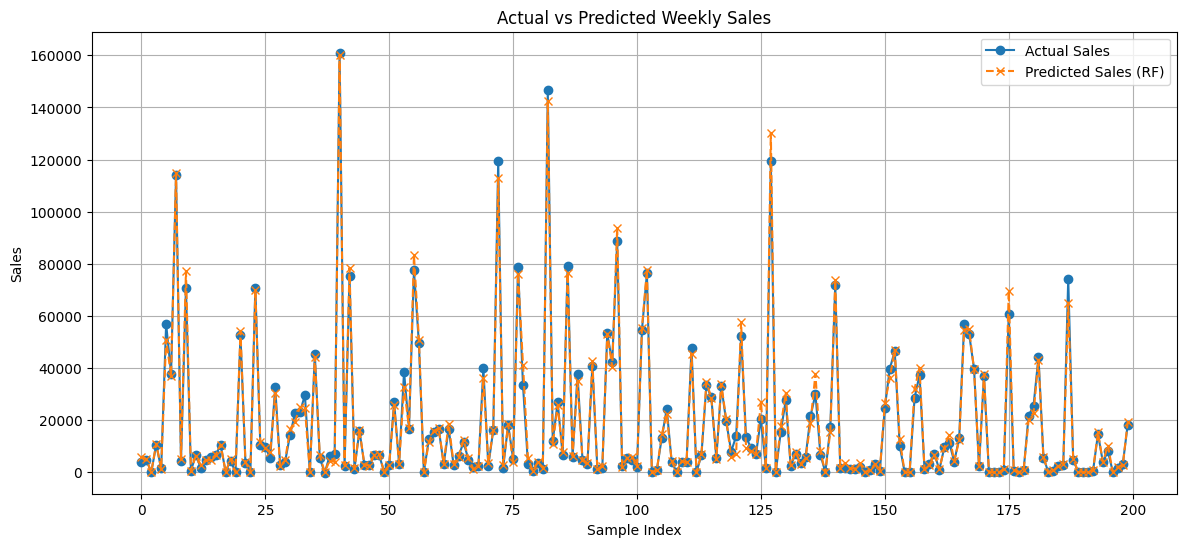

In [12]:
# Sample 200 points for visualization
n = 200
plt.figure(figsize=(14, 6))
plt.plot(y_test.values[:n], label="Actual Sales", marker='o')
plt.plot(rf_preds[:n], label="Predicted Sales (RF)", linestyle='--', marker='x')
plt.title("Actual vs Predicted Weekly Sales")
plt.xlabel("Sample Index")
plt.ylabel("Sales")
plt.legend()
plt.grid()
plt.show()


9. Write Streamlit App

In [13]:
%%writefile app.py
import streamlit as st
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import kagglehub

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

st.set_page_config(page_title="Walmart Sales Forecasting", layout="wide")

st.title("📈 Walmart Sales Forecasting")
st.markdown("""
Predict weekly sales using historical Walmart data.
Includes time-based feature engineering and Random Forest model for forecasting.
""")

# Load dataset using kagglehub
@st.cache_data
def load_dataset():
    path = kagglehub.dataset_download("aslanahmedov/walmart-sales-forecast")
    df = pd.read_csv(path + "/train.csv")
    return df

df = load_dataset()

# Preview dataset
st.subheader("📊 Dataset Preview")
st.dataframe(df.head())

# Feature engineering
df['Date'] = pd.to_datetime(df['Date'])
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Week'] = df['Date'].dt.isocalendar().week.astype(int)
df['Day'] = df['Date'].dt.day
df['DayOfWeek'] = df['Date'].dt.dayofweek

df = df.sort_values(by=['Store', 'Date'])
df['Sales_Lag_1'] = df.groupby('Store')['Weekly_Sales'].shift(1)
df.dropna(inplace=True)

# Model inputs
features = ['Store', 'Dept', 'Year', 'Month', 'Week', 'Day', 'DayOfWeek', 'Sales_Lag_1']
target = 'Weekly_Sales'

X = df[features]
y = df[target]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
preds = model.predict(X_test)

# Evaluation
rmse = np.sqrt(mean_squared_error(y_test, preds))
r2 = r2_score(y_test, preds)

st.subheader("📈 Model Evaluation")
st.metric("RMSE", f"{rmse:.2f}")
st.metric("R² Score", f"{r2:.2f}")

# Visualization
st.subheader("📉 Actual vs Predicted Sales")
n = st.slider("Number of Samples to Plot", 50, 1000, 200)

fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(y_test.values[:n], label='Actual Sales', marker='o')
ax.plot(preds[:n], label='Predicted Sales', linestyle='--', marker='x')
ax.set_title("Actual vs Predicted Weekly Sales")
ax.set_xlabel("Sample Index")
ax.set_ylabel("Sales")
ax.legend()
ax.grid()

st.pyplot(fig)


Writing app.py


10. Install Required Packages

In [17]:
!pip install -q streamlit kagglehub scikit-learn matplotlib
!pip install -q pyngrok


11. Setup ngrok and Run App

In [19]:
from pyngrok import ngrok

# Authenticate ngrok (run only once, or if not already authed)
!ngrok config add-authtoken YOUR_TOKEN_HERE

# ✅ Explicitly define HTTP tunnel on port 8501
public_url = ngrok.connect(addr=8501, proto="http")
print("Streamlit app available at:", public_url)

# ✅ Now start the app
!streamlit run app.py &> /dev/null &


Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml
Streamlit app available at: NgrokTunnel: "https://98a9c26bae0d.ngrok-free.app" -> "http://localhost:8501"
